<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Advanced_RAG_Better_Retrieval_Using_Merger_Retriever_And_Long_Contect_Reorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Techniques to Implement Better RAG systems

* RAG is particularyly helpful when we do not want to finue Models and still want to generate insights from Custom Knowledge Base.
*  Imagine we have multiple audios and videos , then how can we use a mechanism that will help retrive information from these sources and generate insgights based on the user queries.

* RAG comprises of Retrieval and Generation Components
* For Retrieval we use a technique called semantic search and for generation we use a Large Language Model to look at the retrieved chunk and generate a human like response.

## LOTR (Merger Retriever)

* **Lord of the Retrievers**, also known as **MergerRetriever**, takes a list of retrievers as input and merges the results of their get_relevant_documents() methods into a single list.

* The merged results will be a list of documents that are relevant to the query and that have been ranked by the different retrievers.

* The **MergerRetriever** class can be used to improve the accuracy of document retrieval in a number of ways.
  - First, it can combine the results of multiple retrievers, which can help to reduce the risk of bias in the results.
  - Second, it can rank the results of the different retrievers, which can help to ensure that the most relevant documents are returned first.

## Install Required Dependencies

In [2]:
!pip install langchain faiss-cpu huggingface_hub sentence-transformers pypdf cohere

In [18]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [25]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.8/496.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/593.7 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.

In [76]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00


* It is not advisable to create a single knowledge base to create single documents as it would become ambiguous for a retrieval model to retrieve right set of context based on semantic similarity.

* LIM(Lost in Middle) LLMs stuggle in scanning the context which are in the middle of the retrieved documents

* To avoid the above issue to some extent we will create different vectorstores and merging it togther using Merge Retriever.

* Then we will Re-order results to avoid performance degradation using LongContextReorder



In [37]:
import os

from langchain.document_transformers import (
    EmbeddingsClusteringFilter,
    EmbeddingsRedundantFilter,
)
from langchain.embeddings import HuggingFaceEmbeddings, OpenAIEmbeddings,HuggingFaceBgeEmbeddings
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.document_transformers import LongContextReorder
from langchain.retrievers.merger_retriever import MergerRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS,Chroma
from langchain.document_loaders import PyPDFLoader

## Set Up Openai keys

In [19]:
import os
from getpass import getpass
import openai
#
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    OPENAI_API_KEY = getpass("Enter your OpenAI API key: ")
openai.api_key = OPENAI_API_KEY

Enter your OpenAI API key: ··········


## Setup the Embedding Models

In [20]:
hf_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                      model_kwargs={"device":"cpu"},
                                      encode_kwargs = {'normalize_embeddings': False})
hf_bge_embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-large-en",
                                             model_kwargs={"device":"cpu"},
                                             encode_kwargs = {'normalize_embeddings': False})
openai_embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

## Data Processing

In [36]:
loader_mh  = PyPDFLoader("/content/mental_health_Document.pdf")
documnet_mh = loader_mh.load()
print(len(documnet_mh))
loader_esops = PyPDFLoader("/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf")
documnet_esops = loader_esops.load()
print(len(documnet_esops))

13
44


## Split Text into chunks

In [39]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
text_mh = text_splitter.split_documents(documnet_mh)
text_esops = text_splitter.split_documents(documnet_esops)
print(len(text_mh))
print(len(text_esops))

56
50


In [57]:
type(text_mh)

list

In [44]:
text_esops[0]

Document(page_content='Startup Employee Stock \nOptions Plans (ESOPs)  \n \nOverview and Best Practices', metadata={'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf', 'page': 0})

## # Instantiate 2 diff cromadb indexs, each one with a diff embedding.

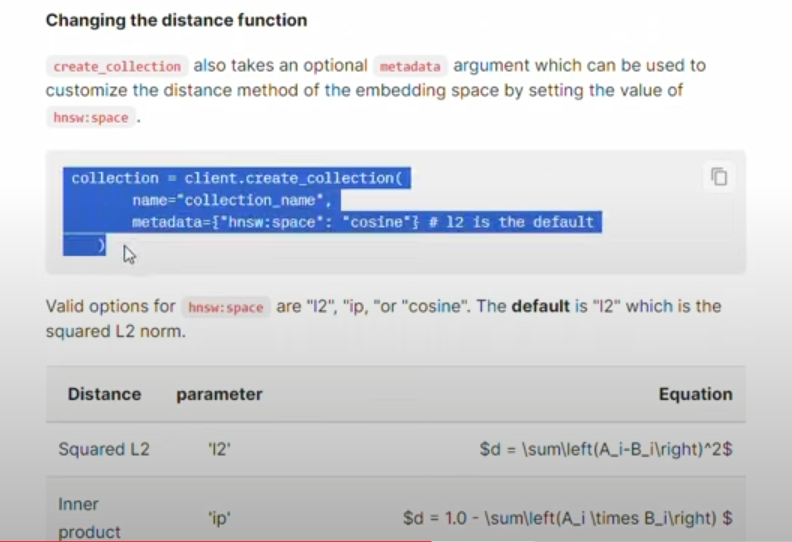

* here we have different embedding models to reduce bias

In [67]:
import chromadb
ABS_PATH = os.path.dirname(os.path.abspath("."))
DB_DIR = os.path.join(ABS_PATH, "db")
#
client_settings = chromadb.config.Settings(
    is_persistent=True,
    persist_directory=DB_DIR,
    anonymized_telemetry=False,
)
#
mh_vectorstore = Chroma.from_documents(text_mh,
                                       hf_bge_embeddings,
                                       client_settings=client_settings,
                                       collection_name="mental_health",
                                       collection_metadata={"hnsw":"cosine"},
                                       persist_directory="/store/mental_health")
esops_vectorstore = Chroma.from_documents(text_esops,
                                          hf_embeddings ,
                                          client_settings=client_settings,
                                          collection_name="esops",
                                          collection_metadata={"hnsw":"cosine"},
                                          persist_directory="/store/mental_health")

In [65]:
os.getcwd()

'/content'

## Load the vectorstore

## Define two different retrievers with two different embeddings and different search type.

In [79]:
retriever_mh = mh_vectorstore.as_retriever(search_type="mmr",
                                  search_kwargs={"k": 5, "include_metadata": True}
                                  )
retriever_esops = esops_vectorstore.as_retriever(search_type="mmr",
                                        search_kwargs={"k": 5, "include_metadata": True}
                                        )

## Merge Retrievers will hold the ouput of boths retrievers and can be used as any other retriever on different types of chains.

In [80]:
lotr = MergerRetriever(retrievers=[retriever_mh, retriever_esops])

In [81]:
for chunks in lotr.get_relevant_documents("What is esops?"):
    print(chunks.page_content)

See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/255657987
Deﬁning mental health and mental illness
Article  · Januar y 2009
CITATIONS
9READS
141,176
2 author s, including:
Some o f the author s of this public ation ar e also w orking on these r elat ed pr ojects:
Cultural P sychiatr y View pr oject
Diversifying the medic al curriculum  View pr oject
Nisha Dogr a
Univ ersity of L eicester
152 PUBLICA TIONS    2,847  CITATIONS    
SEE PROFILE
All c ontent f ollo wing this p age was uplo aded b y Nisha Dogr a on 20 May 2014.
The user has r equest ed enhanc ement of the do wnlo aded file.
ESOPS FOR THE LONG TERM  Part IV
are useful as they relate to ‘societal ’ expectations of children.
Different de ﬁnitions are used to de ﬁne mental ill health. The WHO uses the term ‘mental
disorders ’ broadly, to include mental illness, intellectual disability, personality disorder, sub-
stance dependence and adjustment to adverse life

In [82]:
for chunks in lotr.get_relevant_documents("What is black hole?"):
    print(chunks.page_content)

perspectives, including those relating to children, and of children. This is important as thosewho work in mental health, or are familiar with the ﬁeld, often make the assumption that the
terms used are readily understood by others. The scale of the problem and access to services isoutlined. We then discuss stigma generally, explore the reasons for it and possible sequelae, andthen consider how this relates to children. Finally, interventions to reduce stigma are brie ﬂy
presented. As mentioned in the Introduction, where possible we have referred speci ﬁcally to the
literature relating to children but where this is limited we have drawn from the wider literatureto highlight key issues.
The chapter begins with an exercise which provides a practical context for the theoretical
content and should be borne in mind as you read, and answered once you have ﬁnished the
chapter.
Box 1.1
Exercise
General questions
 What words or images do you associate with the following terms:
 Mental health


## Remove redundant results from the merged retrievers.

In [83]:
# We can remove redundant results from both retrievers using yet another embedding.
# Using multiples embeddings in diff steps could help reduce biases.
filter = EmbeddingsRedundantFilter(embeddings=openai_embeddings)
pipeline = DocumentCompressorPipeline(transformers=[filter])
compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline,
                                                       base_retriever=lotr)

In [84]:
compression_retriever.get_relevant_documents("What is black hole?")[0].page_content

'perspectives, including those relating to children, and of children. This is important as thosewho work in mental health, or are familiar with the ﬁeld, often make the assumption that the\nterms used are readily understood by others. The scale of the problem and access to services isoutlined. We then discuss stigma generally, explore the reasons for it and possible sequelae, andthen consider how this relates to children. Finally, interventions to reduce stigma are brie ﬂy\npresented. As mentioned in the Introduction, where possible we have referred speci ﬁcally to the\nliterature relating to children but where this is limited we have drawn from the wider literatureto highlight key issues.\nThe chapter begins with an exercise which provides a practical context for the theoretical\ncontent and should be borne in mind as you read, and answered once you have ﬁnished the\nchapter.\nBox 1.1\nExercise\nGeneral questions\n\x7f What words or images do you associate with the following terms:\n\

In [90]:
# This filter will divide the documents vectors into clusters or "centers" of meaning.
# Then it will pick the closest document to that center for the final results.
# By default the result document will be ordered/grouped by clusters.
filter_ordered_cluster = EmbeddingsClusteringFilter(
    embeddings=openai_embeddings,
    num_clusters=10,
    num_closest=1,
)
pipeline = DocumentCompressorPipeline(transformers=[filter_ordered_cluster])
compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline, base_retriever=lotr
)

In [91]:
compression_retriever.get_relevant_documents("What is black hole?")[0].page_content

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'Mental health literacy\nFinally, in this section, it is also worth considering how the mental health ‘literacy ’ of adults\nand children in the general population varies from that of professionals. In all phases of a recentresearch project, conceptual confusion was identi ﬁed in the literature review and among ado-\nlescent participants (Leighton 2006, 2008). Focus group participants did not ﬁnd the single\ncontinuum model suggested by the WHO (2000) helpful (Leighton 2006). Furthermore, in thefocus group feedback session, participants suggested that labelling serious mental illnesses suchas schizophrenia and major depression, as ‘mental health problems ’, diminishes the seriousness\nof mental illness, with implications for attitudes towards, and treatment of, those with mentalillness (Leighton 2006). It is also evident that there is considerable confusion for young peoplebetween the terms ‘mental health ’, ‘mental illness ’ and ‘learning disability ’ (Dogra et al.  2007;\nRose et al.

In [92]:
compression_retriever.get_relevant_documents("What is esops?")[0].page_content

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'Kendall, R. (1988) Diagnosis and classi ﬁcation, in R. Kendall and A. Zealley (eds) Companion to Psychiatric\nStudies . Edinburgh: Churchill Livingstone.\nLeighton, S. (2006) Pilot thesis: ‘What do I think? Where do I go? ’ Exploring adolescents ’ understanding of\nmental health issues and their attitudes towards seeking help for mental health problems. Unpublisheddoctoral assignment.16 Nursing in child and adolescent mental health'

In [93]:

# If you want the final document to be ordered by the original retriever scores
# you need to add the "sorted" parameter.
filter_ordered_by_retriever = EmbeddingsClusteringFilter(
    embeddings=openai_embeddings,
    num_clusters=10,
    num_closest=1,
    sorted=True,
)

pipeline = DocumentCompressorPipeline(transformers=[filter_ordered_by_retriever])
compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline, base_retriever=lotr
)

In [94]:
compression_retriever.get_relevant_documents("What is esops?")[0].page_content

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/255657987\nDeﬁning mental health and mental illness\nArticle  · Januar y 2009\nCITATIONS\n9READS\n141,176\n2 author s, including:\nSome o f the author s of this public ation ar e also w orking on these r elat ed pr ojects:\nCultural P sychiatr y View pr oject\nDiversifying the medic al curriculum  View pr oject\nNisha Dogr a\nUniv ersity of L eicester\n152 PUBLICA TIONS \xa0\xa0\xa02,847  CITATIONS \xa0\xa0\xa0\nSEE PROFILE\nAll c ontent f ollo wing this p age was uplo aded b y Nisha Dogr a on 20 May 2014.\nThe user has r equest ed enhanc ement of the do wnlo aded file.'

## Re-order results to avoid performance degradation.


In [126]:
lotr = MergerRetriever(retrievers=[retriever_mh, retriever_esops])
query = "What is ESOPS?"
docs = lotr.get_relevant_documents(query)
docs

[Document(page_content='See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/255657987\nDeﬁning mental health and mental illness\nArticle  · Januar y 2009\nCITATIONS\n9READS\n141,176\n2 author s, including:\nSome o f the author s of this public ation ar e also w orking on these r elat ed pr ojects:\nCultural P sychiatr y View pr oject\nDiversifying the medic al curriculum  View pr oject\nNisha Dogr a\nUniv ersity of L eicester\n152 PUBLICA TIONS \xa0\xa0\xa02,847  CITATIONS \xa0\xa0\xa0\nSEE PROFILE\nAll c ontent f ollo wing this p age was uplo aded b y Nisha Dogr a on 20 May 2014.\nThe user has r equest ed enhanc ement of the do wnlo aded file.', metadata={'page': 0, 'source': '/content/mental_health_Document.pdf'}),
 Document(page_content='ESOPS FOR THE LONG TERM  Part IV', metadata={'page': 34, 'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf'}),
 Document(page_content='are useful as they relat

## Reordered Docs (Tackling Lost in the Middle)

In [106]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(docs)
reordered_docs

[Document(page_content='ESOPS FOR THE LONG TERM  Part IV', metadata={'page': 34, 'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf'}),
 Document(page_content='What is an ESOP?  \n•An Employee Stock Options Plan (ESOP)  \n \n•An allocation  of shares that will be granted to employees in the future \nin the form of stock options  \n–How much equity should we set aside for employees?  \n \n•A plan for how these options will be distributed:  \n–How many shares will individual employees receive?  \n–What terms will govern these grants?  \n \n•The plan is as important as the allocation!', metadata={'page': 3, 'source': '/content/Employee-Stock-Option-Plans-ESOP-Best-Practices-2.pdf'}),
 Document(page_content='Late-VC Flush with capital,  startups at this stage \nbegin to steadily ramp -up hiring, yet \nemployees still want equity  Important to have standardized the  \nESOP and the amount of equity granted \nto new hires at each level  \nGrowth  Company is aggressively

## Setup Filtering and LongContext Retriever Pipline

In [124]:
from re import search
filter = EmbeddingsRedundantFilter(embeddings=openai_embeddings)
reordering = LongContextReorder()
pipeline = DocumentCompressorPipeline(transformers=[filter, reordering])
compression_retriever_reordered = ContextualCompressionRetriever(
    base_compressor=pipeline, base_retriever=lotr,search_kwargs={"k": 5, "include_metadata": True}
)

In [125]:
docs = compression_retriever_reordered.get_relevant_documents("What is esops?")
len(docs)

10

In [103]:
compression_retriever_reordered.get_relevant_documents("What is black hole?")[0].page_content

'Strike Price  \n•Options are “struck” at a specific strike price when issued; the holder \nmust pay this amount in order to exercise the option  \n–The expectation is that the shares will have significantly increased \nin value, and the holder will profit from the spread  \n–Regulations for how strike prices can be set will vary by region  \n•However, it is generally in the best interest of both company and \nemployee if the strike price is set as low as possible  \n–This is because options are typically exercised only after an \nacquisition or IPO, so while a higher strike price costs the \nemployee more, none of the current shareholders benefit  The strike price is the amount that the employee must pay to turn one \noption into one share of stock. Also known as the “exercise price”'

In [104]:
compression_retriever_reordered.get_relevant_documents("What is the stigma associated with mental health?")[0].page_content

'Social Impact Considerations  \n•Companies focused on social impact goals and/or in developing \nmarkets may have unique ESOP considerations  \n•Consider two possible scenarios:  \n–Financial Inclusion Goals : Employee -friendly hiring practices and \nESOPs can help build local financial inclusion. If this is part of your \ncorporate mandate, consider the added social impact value of \noffering your options program to all levels of employees  \n–Local Ownership Culture : Conversely, in certain regions stock \noptions may have negligible value to employees, either because of \nrisk aversion, lack of liquidity, or lack of understanding. If this is the \ncase, it is not worth extensively offering options to employees who \nwould rather be paid in cash'

## Implementing Generation PipeLine Using Langchain

In [144]:
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
#
llm = OpenAI(openai_api_key = OPENAI_API_KEY,
             temperature=0.1,
             max_tokens=256)
#
qa = RetrievalQA.from_chain_type(
      llm=llm,
      chain_type="stuff",
      retriever = compression_retriever_reordered,
      return_source_documents = True
)

In [116]:
results = qa(query)

In [119]:
results["query"]

'What is ESOPS?'

In [120]:
results["result"]

' An Employee Stock Options Plan (ESOP) is an allocation of shares that will be granted to employees in the future in the form of stock options. The plan is as important as the allocation and should be set up sometime between the pre-seed and early-VC stage. It is important to engage an experienced startup lawyer with regional expertise to standardize the terms and language.'

In [123]:
len(results["source_documents"])

10

In [127]:
results = qa("What is the social stigma associated with mental health?")

In [128]:
results["result"]

' People with mental health problems are often viewed negatively and labeled with derogatory terms such as "retarded", "psycho", "spastic", "mental", "crazy", and "nutter". They are often seen as dangerous and unpredictable, and are believed to respond poorly to treatment with poor outcomes. They are also seen as difficult to communicate with, which can lead to social exclusion.'

##Query 2

In [129]:
results = qa("How to determine Dollar Value of the Options Grant")

In [130]:
results["result"]

' The dollar value of the options grant is determined by multiplying the number of shares by the current share price.'

## Query2 - Reordered retrieved documents

In [131]:
results["source_documents"][0].page_content

'5. Calculate the Options Grant  \nOptions Grant  \n(Number of Shares)  = Dollar Value  \nof Options Grant  \nCurrent Share Price'

In [132]:
results["source_documents"][1].page_content

'value of an options grant  \n•Easy for employees to grasp  what they \nare really getting (“$200,000 is a lot”)  \n•Grounds negotiations  in a discussion \nabout concrete dollar amounts, rather \nthan a percent of the company  \nNote: Although we recommend communicating options packages as a dollar value, we do not suggest \nrefusing employees information about their effective percentage ownership ; all options holders are \nentitled to this information, and to refuse would be unethical .'

In [133]:
results["source_documents"][2].page_content

'Year 2 Hires\nSales Director $70,000 0.30x $21,000 42 0.42% 42 0.35%\nSalesperson $40,000 0.10x $4,000 8 0.08% 8 0.07%\nEngineer $60,000 0.25x $15,000 30 0.30% 30 0.25%\nYear 3 Hires\nMarketing Director $60,000 0.30x $18,000 14 0.12%\nEngineer $50,000 0.25x $12,500 10 0.08%\nSalesperson $40,000 0.10x $4,000 3 0.03%\nOffice Manager $30,000 0.10x $3,000 2 0.02%\nFounding team shares are \nnegotiated as a percentage of the \ncompany; all future employees \nreceive grants determined in dollars  \nRetention grants are awarded every two \nyears after an initial options package  The “true” valuation (an \ninternal estimate) increases \nmarginally as the company \nbuilds value…  …but increases significantly when \nthe company raises a new round, \nwhich also increases the share \ncount and dilutes all equity owners  \nFor all new hires after the \nfounding team, options grants \nare awarded based on the \nemployee’s options multiplier \nand baseline salary'

## Query 3

In [145]:
results = qa("What has been mentioned about Children, mental illness and stigma?")

In [146]:
results["result"]

" It has been mentioned that children develop negative attitudes towards those with mental illness early on, that adolescents' beliefs and attitudes regarding mental health and illness will affect service development, the quality of life of those experiencing mental health problems and the help-seeking behaviour of individuals, and that there is a scarcity of research examining the issue of stigma in relation to children and mental illness."

## Query3 - Reordered retrieved documents

In [140]:
results['source_documents'][0].page_content

'Social Impact Considerations  \n•Companies focused on social impact goals and/or in developing \nmarkets may have unique ESOP considerations  \n•Consider two possible scenarios:  \n–Financial Inclusion Goals : Employee -friendly hiring practices and \nESOPs can help build local financial inclusion. If this is part of your \ncorporate mandate, consider the added social impact value of \noffering your options program to all levels of employees  \n–Local Ownership Culture : Conversely, in certain regions stock \noptions may have negligible value to employees, either because of \nrisk aversion, lack of liquidity, or lack of understanding. If this is the \ncase, it is not worth extensively offering options to employees who \nwould rather be paid in cash'

In [148]:
results['source_documents'][-3].page_content

'applicable to children.\nConsequences of stigma\nStigmatization of the mentally ill is understood to be prejudicial to them, injurious to all aspectsof their treatment in mental health services and damaging to their role as members of society(Hinshaw 2005). Stigmatization leads to individual and social discrimination against the stig-matized person. Several authors identify that the discriminatory behaviour displayed can behostile or avoidant and that it operates throughout personal and social relationships, pervadingthe home, workplace, local community, health and social welfare systems. This can result inincreased feelings of shame, increased personal and social impairment and isolation, perpetu-ation and worsening of an illness, reluctance to access health care and infringement of humanrights (Link and Phelan 2001; Crisp 2004; Hinshaw 2005).\nChildren, mental illness and stigma'

In [147]:
results['source_documents'][-2].page_content

'Deﬁning mental health and\nmental illness\nSharon Leighton and Nisha Dogra\nKey features \x7fDiscussion of the terminological confusion that exists in relation to issues\nassociated with mental health.\n\x7fThe scale of individual suffering from mental health problems and illness\namong young people.\n\x7fThe worldwide phenomenon of the stigmatization of mental illness,\noriginating during childhood.\n\x7fEvidence regarding interventions to reduce stigma.\nIntroduction\nIn this chapter we explore the concepts of mental health and mental illness from different\nperspectives, including those relating to children, and of children. This is important as thosewho work in mental health, or are familiar with the ﬁeld, often make the assumption that the'

In [143]:
results

{'query': 'What has been mentioned about Children, mental illness and stigma?',
 'result': " It has been mentioned that children develop negative attitudes towards those with mental illness early on, that adolescents' beliefs and attitudes regarding mental health and illness will affect service development, the quality of life of those experiencing mental health problems and the help-seeking behaviour of individuals, and that there is a scarcity of research examining the issue of stigma in relation to children and mental illness.",
 'source_documents': [_DocumentWithState(page_content='Social Impact Considerations  \n•Companies focused on social impact goals and/or in developing \nmarkets may have unique ESOP considerations  \n•Consider two possible scenarios:  \n–Financial Inclusion Goals : Employee -friendly hiring practices and \nESOPs can help build local financial inclusion. If this is part of your \ncorporate mandate, consider the added social impact value of \noffering your opti